In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial import ConvexHull
import scanpy.external as sce
import scanpy as sc
import scipy

from importlib import reload

# locals
import utils as ut
import plotting as plt2

In [2]:
# break

# load BJ Fib data

In [3]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.h5ad"
fbdata = sc.read_h5ad(fpath)
fbdata = fbdata[fbdata.obs['dataset'] == 'chen_2015', :]

# extract most highly expressed genes
var = fbdata.var.copy()
var = var.reset_index()
var['mean_expression'] = fbdata.X.mean(axis=0)
var = var.sort_values(by='mean_expression', ascending=False)

columns = [
    'gene_name',
    'gene_biotype',
    'mean_expression',
]
var[columns].head(10)

,gene_name,gene_biotype,mean_expression
9991,MT-CO1,protein_coding,122144.444444
205,ACTB,protein_coding,100214.277778
9998,MT-ND4,protein_coding,87604.166667
9993,MT-CO3,protein_coding,83216.833333
9992,MT-CO2,protein_coding,59432.222222
10000,MT-ND5,protein_coding,50758.888889
208,ACTG1,protein_coding,47903.388889
1362,B2M,protein_coding,39259.611111
8665,LCP1,protein_coding,38850.722222
6092,GAPDH,protein_coding,36161.777778


In [4]:
fbdata.layers["raw_counts"] = fbdata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(fbdata)
# Logarithmize the data
sc.pp.log1p(fbdata)

fbdata

/tmp/ipykernel_3248761/1872020376.py:1: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  fbdata.layers["raw_counts"] = fbdata.X.copy()


AnnData object with n_obs × n_vars = 18 × 19393
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id'
    uns: 'log1p'
    layers: 'raw_counts'

# Load iHSC data

In [5]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [6]:
adata.var_names[:10]

Index(['ATAD3B', 'SKI', 'PEX14', 'PLCH2', 'SPSB1', 'HES3', 'PLEKHM2', 'CA6',
       'NMNAT1', 'CCDC27'],
      dtype='object')

In [87]:
# Combine the expression

common_genes = set(fbdata.var_names) & set(adata.var_names)  
common_genes_list = list(common_genes) 
print("Shared genes: ", len(common_genes_list))

labels = ["iHSC"] * len(adata.obs) + ["BJ"] * len(fbdata.obs)

# Combine the dataframes, reset the index so it doesn't interfere and add the label
df = pd.concat([
    adata.to_df()[common_genes_list].reset_index(drop=True),
    fbdata.to_df()[common_genes_list].reset_index(drop=True),
])
df['source'] = labels
print(f"{df.shape=}")
df.head()

Shared genes:  15065
df.shape=(8581, 15066)


,RSPH9,FGF11,HPS6,PCDHGB5,CLNK,WNK1,TCP11L1,TRIM64C,KRTAP5-10,TRMT5,...,DAOA,PSMD14,AGMAT,IDS,SDHAF4,AMN1,ADIPOR1,ALPI,MFSD4B,source
0,0.000000,0.0,0.000000,0.000000,0.0,0.926184,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.926184,0.000000,0.0,0.000000,iHSC
1,1.037502,0.0,1.037502,1.535644,0.0,0.000000,0.0,0.0,0.0,1.037502,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,iHSC
2,0.000000,0.0,1.196788,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.196788,0.0,0.000000,iHSC
3,0.000000,0.0,0.000000,0.000000,0.0,1.362332,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,iHSC
4,0.000000,0.0,0.526588,0.869740,0.0,0.526588,0.0,0.0,0.0,0.526588,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.526588,iHSC


In [109]:
table = df.groupby('source').max().T.reset_index(names='gene_name')
table['diff'] = table['BJ'] - table['iHSC']
table['diff_ab'] = table['diff'].abs()

pang = adata.uns['panglaodb'].copy()

for cell_type, group in pang.groupby('cell_type'):
    table[cell_type] = table['gene_name'].isin(group['gene_name'].values)

table = table.sort_values(by='diff')
table.head()

source,gene_name,BJ,iHSC,diff,diff_ab,B cells memory,B cells naive,Basophils,Dendritic cells,Endothelial cells,...,Macrophages,Megakaryocytes,Monocytes,Myeloid-derived suppressor cells,Neutrophils,Osteoblasts,Plasma cells,Plasmacytoid dendritic cells,Reticulocytes,Stromal cells
3877,CEACAM3,0.0,7.102735,-7.102735,7.102735,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1880,KIR2DL3,0.0,5.735417,-5.735417,5.735417,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
708,NPY5R,0.0,5.663839,-5.663839,5.663839,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8246,TPSAB1,0.0,5.592402,-5.592402,5.592402,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3403,GIMAP1-GIMAP5,0.0,5.575594,-5.575594,5.575594,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Plots

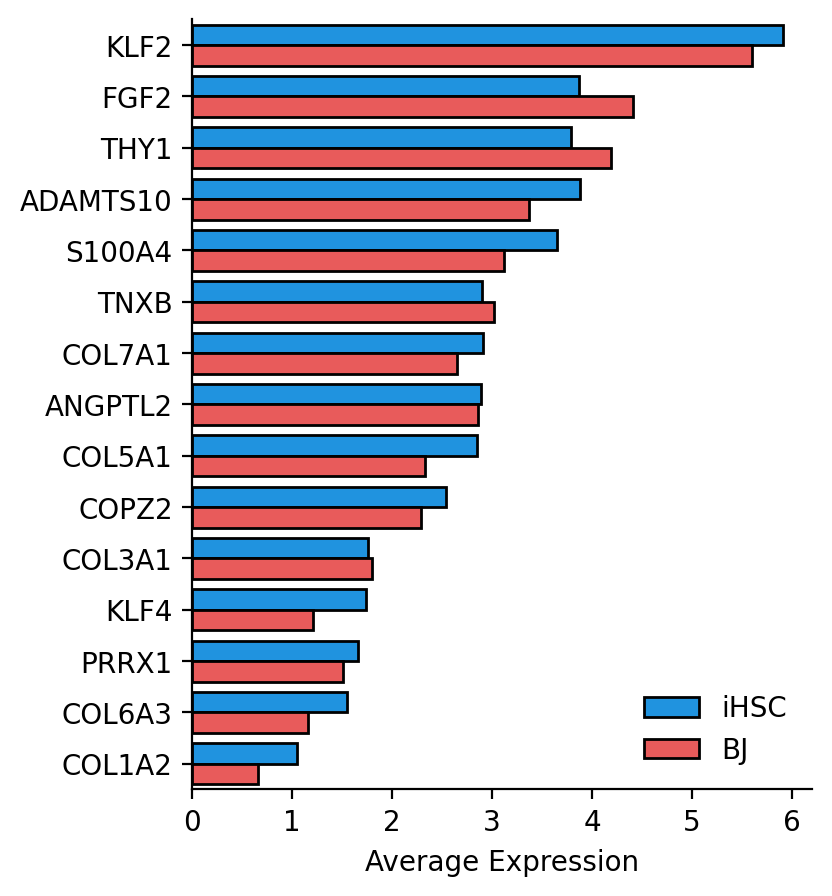

In [146]:
n = 15
pdf = table.copy()

pdf = pdf[(pdf['BJ'] > 0) & pdf['iHSC'] > 0]
pdf = pdf[pdf['Fibroblasts']]

pdf = pdf.sort_values(by='diff_ab')

pdf = pd.melt(
    pdf.head(n), 
    id_vars='gene_name',
    value_vars=['BJ', 'iHSC'],
)

pdf = pdf.sort_values(by='value', ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 5

sns.barplot(
    data=pdf,
    y='gene_name',
    x='value',
    hue='source',
    ec='k',
    palette= ["#0099FF", "#FF4444"] ,
)

plt.gca()

plt.xlabel("Average Expression")
plt.ylabel("")

sns.move_legend(
    plt.gca(),
    loc='best',
    frameon=False,
    title="",
)

sns.despine()

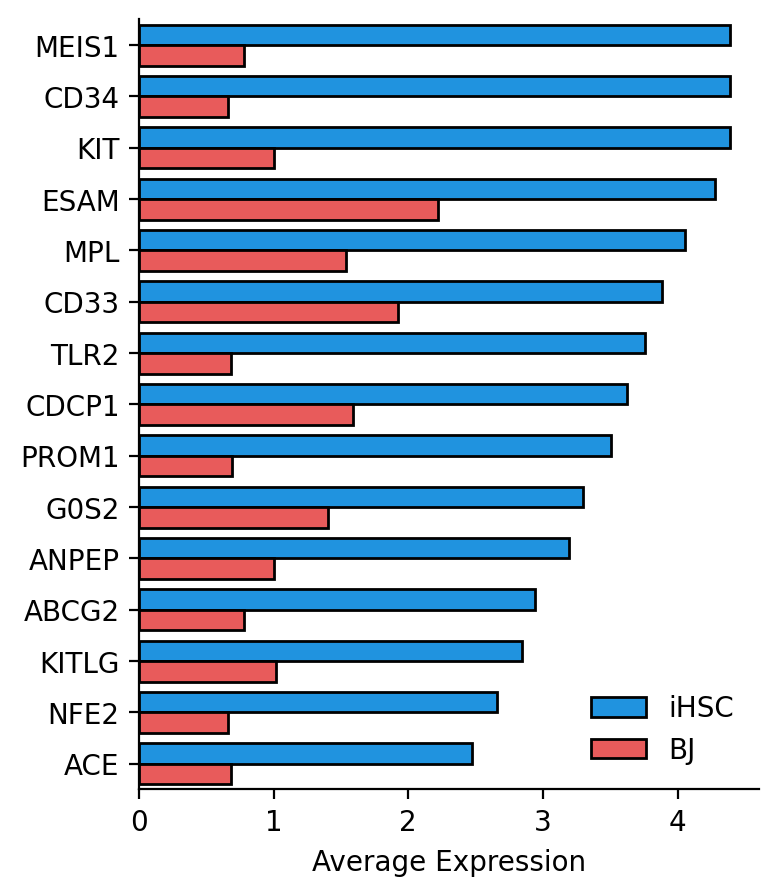

In [150]:
n = 15
pdf = table.copy()

pdf = pdf[(pdf['BJ'] > 0) & pdf['iHSC'] > 0]
pdf = pdf[pdf['Hematopoietic stem cells']]

pdf = pdf.sort_values(by='diff', ascending=True,)

pdf = pd.melt(
    pdf.head(n), 
    id_vars='gene_name',
    value_vars=['BJ', 'iHSC'],
)

pdf = pdf.sort_values(by='value', ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 5

sns.barplot(
    data=pdf,
    y='gene_name',
    x='value',
    hue='source',
    ec='k',
    palette= ["#0099FF", "#FF4444"],
)

plt.gca()

plt.xlabel("Average Expression")
plt.ylabel("")

sns.move_legend(
    plt.gca(),
    loc='best',
    frameon=False,
    title="",
)

sns.despine()

In [ ]:
cluster_genes = adata.var[adata.var['cluster_genes']]
cluster_genes.head()

# get cluster count table

In [ ]:
table = adata.obs['cluster_str'].value_counts().reset_index()
table['percent'] = table['count'] / table['count'].sum()

print(table.to_latex(index=False))

In [ ]:
3927 + 1708

# Spiked in cells

In [ ]:
fpath = "/home/cstansbu/git_repositories/ONT-single-cell/resources/spiked_in_candidates.csv"
df = pd.read_csv(fpath)
df.head()

In [ ]:
adata.obs['cell_id'] = adata.obs.index.copy()
adata.obs['candidate'] = adata.obs['cell_id'].isin(df['barcode'].values)
adata.obs.head()

In [ ]:
table = adata.obs[['cluster_str', 'candidate']].value_counts().reset_index()
table = table.sort_values(by=['cluster_str', 'candidate'], )

print(table.to_latex(index=False))

In [ ]:
(516 + 293) / 8563

In [ ]:
(293 + 516) / 8500

In [ ]:
break